In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
import hublib.use
import numpy as np

style = {'description_width': 'initial'}

<IPython.core.display.Javascript object>

In [2]:
e_np = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const inside NP:',
    style=style,
)
e_np

BoundedFloatText(value=78.5, description='Dielectric const inside NP:', max=78.5, min=2.0, step=0.1, style=DescriptionStyle(description_width='initial'))

In [3]:
e_out = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const outside NP:',
    style=style,
)
e_out

BoundedFloatText(value=78.5, description='Dielectric const outside NP:', max=78.5, min=2.0, step=0.1, style=DescriptionStyle(description_width='initial'))

In [4]:
pion = widgets.Dropdown(
    options={'1(monovalent)': 1, '2(divalent)': 2, '3(trivalent)': 3},
    value=1,
    description="Positive Ion Valency (z)",
    style=style
)
pion

Dropdown(description='Positive Ion Valency (z)', options={'1(monovalent)': 1, '2(divalent)': 2, '3(trivalent)': 3}, style=DescriptionStyle(description_width='initial'), value=1)

In [5]:
c_out = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=0.4,
    step=0.1,
    description='salt concentration outside:',
    style=style
)
c_out

BoundedFloatText(value=0.0, description='salt concentration outside:', max=0.4, step=0.1, style=DescriptionStyle(description_width='initial'))

In [6]:
np_radius = widgets.BoundedFloatText(
    value=2.6775,
    min=2,
    max=5,
    step=0.001,
    description='Nanoparticle Radius (nm):',
    style=style
)
np_radius

BoundedFloatText(value=2.6775, description='Nanoparticle Radius (nm):', max=5.0, min=2.0, step=0.001, style=DescriptionStyle(description_width='initial'))

In [7]:
np_charge = widgets.BoundedFloatText(
    value=-60,
    min=-300,
    max=-30,
    step=-1,
    description='Nanoparticle Charge:',
    style=style
)
np_charge

BoundedFloatText(value=-60.0, description='Nanoparticle Charge:', max=-30.0, min=-300.0, step=-1.0, style=DescriptionStyle(description_width='initial'))

In [8]:
steps = widgets.BoundedIntText(
    value=5000,
    min=5000,
    max=5000000,
    step=100000,
    description='Simulation Steps:',
    style=style,
)
steps

BoundedIntText(value=5000, description='Simulation Steps:', max=5000000, min=5000, step=100000, style=DescriptionStyle(description_width='initial'))

In [9]:
label_style = "style='background-color: #DCDCDC; font-size:200; padding: 5px'"
def make_label(name, desc=""):
    lval = '<p  %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Physical', '')
clabel = make_label('Computing', '')

In [10]:
image_html = widgets.HTML(
    value='<img src="../webcontent/images/overview.jpg" style="width: 500px"/>',
)
image_html

HTML(value='<img src="../webcontent/images/overview.jpg" style="width: 500px"/>')

In [18]:
about=widgets.Textarea(
    value='This app enables users to simulate ions confined between nanoparticle (NP) surfaces in aqueous media. Nanoparticles can be synthetic (such as gold NPs) or natural (e.g. proteins) and the length of confinement is of the order of nanometers. Example systems include ion channel proteins of the cell membrane, adsorbed ions near surfaces of porous electrodes, and ions confined by NPs and/or colloidal particles. NP surfaces are assumed to be unpolarizable and are modeled as planar interfaces considering the large size difference between the ions and the NPs. \nThe app facilitates investigations for a wide array of ionic and environmental parameters. Users can extract the ionic structure (density profile) and study its dependence on salt concentration (c), ion valency (z), and other physical attributes. \nUsers can explore interesting effects by changing the c parameter from 0.3 to 0.9 M. This increase in density leads to crowding of the channel (confinement) with a large number of ions. The effect of symmetry breaking caused by the surfaces is seen: to avoid being pushed by ions from both the sides, an ion prefers the interface over the central region (bulk). The app enables users to explore this effect of ion accumulation near the interface, and make a quantitative assessment of ionic structure in strong confinement.\nAnother rich avenue to explore is to tune the valency of positive ions (parameter z) from 1 to 3. A positively-charged multivalent ion (+3 Fe or +2 Ca) near an interface is pulled away from the interface by oppositely charged ions with a stronger force relative to the bulk where the symmetry allows for no preferred movement. Thus, stronger electrostatic interactions (as in the case of multivalent ions) tend to cause depletion of the ions from the interface. This app empowers users to investigate this depletion effect via accurate computation of the density profiles of ions. \nEffects of changing other physical attributes such as confinement length and ion size are also available for users to explore. We invite users to take an inside look at what happens to the self-assembly of ions in these nanoscale channels by investigating the interplay of electrostatic effects and steric (or entropic) effects caused due to confinement, and measuring associated density profiles. \nWhile we provide a default of 20000 steps for users to get started on exploring different features of the app by obtaining immediate results, converged results of smooth profiles are expected for around 1 million steps.',
    placeholder='',
    layout={'height': '150px','width': '100%'},
    disabled=True
)
about

Textarea(value='This app enables users to simulate ions confined between nanoparticle (NP) surfaces in aqueous media. Nanoparticles can be synthetic (such as gold NPs) or natural (e.g. proteins) and the length of confinement is of the order of nanometers. Example systems include ion channel proteins of the cell membrane, adsorbed ions near surfaces of porous electrodes, and ions confined by NPs and/or colloidal particles. NP surfaces are assumed to be unpolarizable and are modeled as planar interfaces considering the large size difference between the ions and the NPs. \nThe app facilitates investigations for a wide array of ionic and environmental parameters. Users can extract the ionic structure (density profile) and study its dependence on salt concentration (c), ion valency (z), and other physical attributes. \nUsers can explore interesting effects by changing the c parameter from 0.3 to 0.9 M. This increase in density leads to crowding of the channel (confinement) with a large number of ions. The effect of symmetry breaking caused by the surfaces is seen: to avoid being pushed by ions from both the sides, an ion prefers the interface over the central region (bulk). The app enables users to explore this effect of ion accumulation near the interface, and make a quantitative assessment of ionic structure in strong confinement.\nAnother rich avenue to explore is to tune the valency of positive ions (parameter z) from 1 to 3. A positively-charged multivalent ion (+3 Fe or +2 Ca) near an interface is pulled away from the interface by oppositely charged ions with a stronger force relative to the bulk where the symmetry allows for no preferred movement. Thus, stronger electrostatic interactions (as in the case of multivalent ions) tend to cause depletion of the ions from the interface. This app empowers users to investigate this depletion effect via accurate computation of the density profiles of ions. \nEffects of changing other physical attributes such as confinement length and ion size are also available for users to explore. We invite users to take an inside look at what happens to the self-assembly of ions in these nanoscale channels by investigating the interplay of electrostatic effects and steric (or entropic) effects caused due to confinement, and measuring associated density profiles. \nWhile we provide a default of 20000 steps for users to get started on exploring different features of the app by obtaining immediate results, converged results of smooth profiles are expected for around 1 million steps.', disabled=True, layout=Layout(height='150px', width='100%'), placeholder='')

In [12]:
pdX=[]
pdY=[]

def callExe(s):
    global pdX, pdY
    
    e_np_value = e_np.value
    e_out_value = e_out.value
    pion_value = pion.value
    c_out_value = c_out.value
    np_radius_value = np_radius.value
    np_charge_value = np_charge.value
    sim_steps_value = steps.value
    walltime = 10
    total_processors = 1
    
    print("Epsilon inside NP is", e_np_value)
    print("Epsilon outside NP is", e_out_value)
    print("Positive Ion Valency is", pion_value)
    print("Salt concentration outside is", c_out_value)
    print("Sphere(NP) radius is", np_radius_value)
    print("NP charge is", np_charge_value)
    print("simulation time step is", sim_steps_value)
    print ("Requested walltime is ",walltime)
    print ("Requested total_processors are ", total_processors)
    
    shutil.rmtree('datafiles',True)
    if not os.path.exists('datafiles'):
        os.makedirs('datafiles')
    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'):
        os.makedirs('outfiles')
    shutil.rmtree('verifiles',True)
    if not os.path.exists('verifiles'):
        os.makedirs('verifiles')

    %use boost-1.62.0-mpich2-1.3-gnu-4.7.2
    # forcing OpenMP thread size, comment when deploying
    os.environ["OMP_NUM_THREADS"] = "1"

    runName=''
    
    #computing parameters are scaled here.
    hiteqm_P =int(sim_steps_value * 0.1);
    writedata_U =int(sim_steps_value * 0.1);
    writedensity_W =int(sim_steps_value * 0.1);
    extra_compute_X = int(sim_steps_value * 0.01);
    moviefreq_F = int(sim_steps_value * 0.01);
    cpmd_verify_Y = int(sim_steps_value * 0.1); 
    
    #submit_str = '--local -p "@@Vin=%d:%d in %d" /apps/pegtut/current/examples/capacitor_voltage/sim1.py  --Vin=@@Vin' % (vin.value[0], vin.value[1], steps.value)
    
    paraList = ' -a ' + str(np_radius_value) + ' -b ' + str(14.28) + ' -e ' + str(e_np_value) + ' -E ' + str(e_out_value) \
    + ' -V ' + str(np_charge_value) + ' -v ' + str(pion_value) + ' -g ' + str(132) + ' -m ' + str(6) + ' -t ' \
    + str(0.001) + ' -s ' + str(10000) + ' -p ' + str(100) + ' -f ' + str(10) + ' -M ' + str(6) + ' -T ' \
    + str(0.001) + ' -k ' + str(0.0025) + ' -q ' + str(0.001) + ' -L ' + str(5) + ' -l ' + str(5) \
    + ' -S ' + str(sim_steps_value) + ' -P ' + str(hiteqm_P) + ' -F ' + str(moviefreq_F) \
    + ' -X ' + str(extra_compute_X) + ' -U ' + str(writedata_U) + ' -Y ' + str(cpmd_verify_Y) \
    + ' -W ' + str(writedensity_W) + ' -B ' + str(0.025)
    
    
    try:
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
         
        submit_str = '--local mpirun -np 1 ./np_electrostatics_lab' + paraList
        #submit_str = '--local pwd'
        s.run(runName, submit_str)
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of np_electrostatics_lab')
        sys.stderr.write(str(e))
        sys.exit(1)
        
    
        
  

In [13]:
# after the run finished, optionally do something
# with the output
def plot_data(s, rdir):
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    plt.clf()  # clear old plot
    plt.figure('Distribution of positive ions near the nanoparticle surface')
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        density_profile = np.loadtxt('outfiles/density_profile.dat')
    except:
        sys.stderr.write('Can not find the positive density results file')
        sys.exit(1)
        
    x = density_profile[:,0]
    y = density_profile[:,1]
    yrr = density_profile[:,2]
    plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    
    plt.show()

<IPython.core.display.Javascript object>


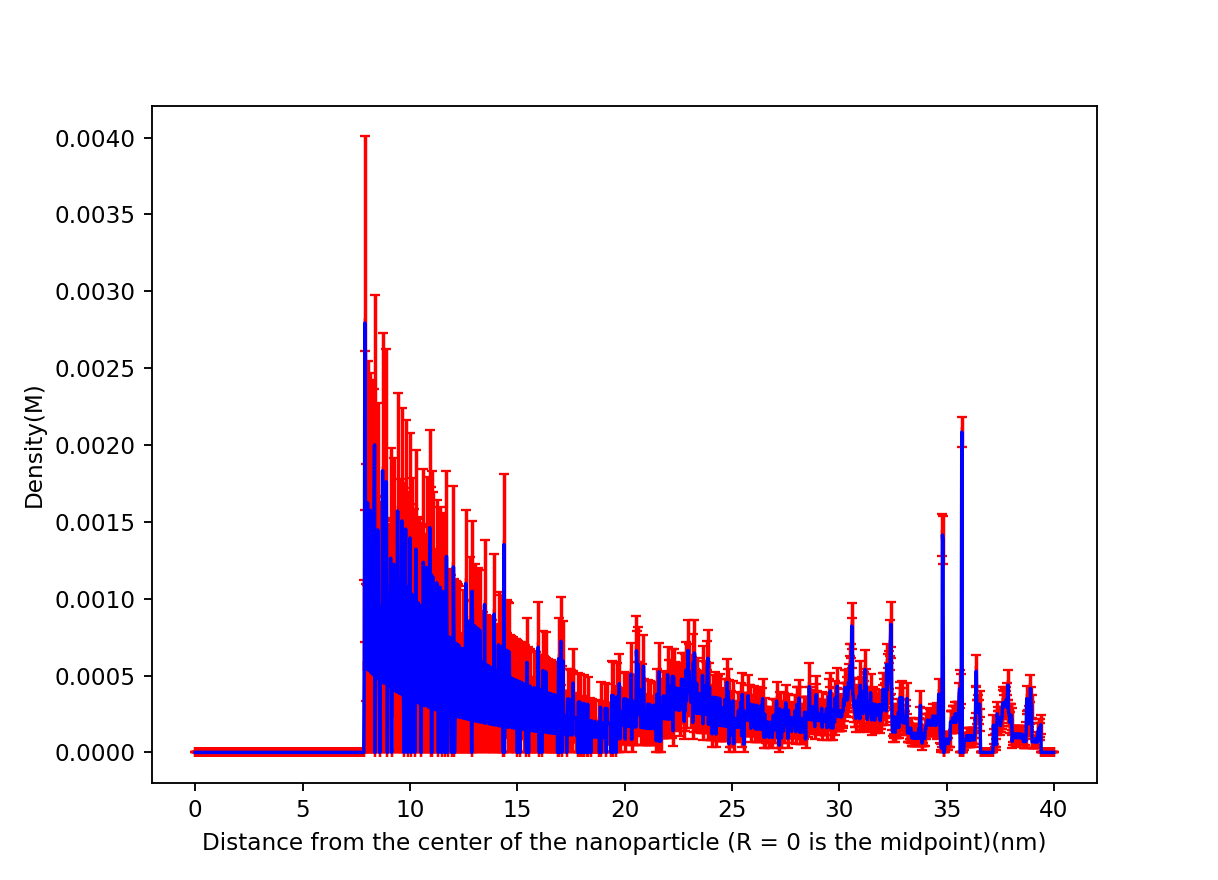

In [14]:
# we want the plot to go here, so create an empty one initially
plt.figure('Distribution of positive ions near the nanoparticle surface')
plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
plt.ylabel('Density(M)', fontsize=10)
plt.show()

In [15]:
#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
Submit(start_func=callExe, done_func=plot_data)


VBox(children=(Button(button_style='success', description='Run', style=ButtonStyle(), tooltip='Run Simulation'),))

Epsilon inside NP is 78.5
Epsilon outside NP is 78.5
Positive Ion Valency is 1
Salt concentration outside is 0.0
Sphere(NP) radius is 2.6775
NP charge is -60.0
simulation time step is 5000
Requested walltime is  10
Requested total_processors are  1
